In [1]:
import os
from concurrent.futures import ThreadPoolExecutor
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
from scipy.signal import convolve2d

### Paralell program

In [2]:
def sua_funcao(input1, input2):
    # Substitua esta função pela sua lógica de processamento
    time.sleep(2)  # Simulando uma operação demorada
    resultado = input1 + input2
    return resultado

def executar_em_paralelo(input1, input2):
    # Número de threads a serem usadas
    num_threads = 2

    # Criando um ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Iniciando as operações em paralelo
        futures = [executor.submit(sua_funcao, input1, input2) for _ in range(num_threads)]

        # Aguardando a conclusão de todas as operações
        resultados = [future.result() for future in futures]

    return resultados

# Exemplo de uso
input1 = 10
input2 = 20
resultados_paralelos = executar_em_paralelo(input1, input2)
print("Resultados em paralelo:", resultados_paralelos)


Resultados em paralelo: [30, 30]


In [11]:
from concurrent.futures import ThreadPoolExecutor
import time

def sua_funcao(par_inputs):
    # Substitua esta função pela sua lógica de processamento
    resultado = sum(par_inputs)  # Exemplo simples, pode ser mais complexo
    return resultado

def executar_em_paralelo(lista_pares_inputs):
    # Número de threads a serem usadas
    num_threads = os.cpu_count()

    # Criando um ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Iniciando as operações em paralelo
        futures = [executor.submit(sua_funcao, par) for par in lista_pares_inputs]

        # Aguardando a conclusão de todas as operações
        resultados = [future.result() for future in futures]

    # Criando o dicionário associando cada resultado aos seus inputs
    resultados_dict = {par: resultado for par, resultado in zip(lista_pares_inputs, resultados)}
    return resultados_dict

# Exemplo de uso
lista_pares_inputs = [(1, 2), (5, 6), (3, 4)]
resultados_paralelos = executar_em_paralelo(lista_pares_inputs)
print("Resultados em paralelo:", resultados_paralelos)


Resultados em paralelo: {(1, 2): 3, (5, 6): 11, (3, 4): 7}


### Running the code for multiple calues of densities

In [8]:
import functions as f

In [9]:
def generate_heatmap(data,title):
    # Extrair chaves e valores do dicionário
    keys = list(data.keys())
    values = list(data.values())

    # Obter valores únicos de agentDensity e residentRelativeDensity
    agent_density_values = np.unique([key[0] for key in keys])
    relative_density_values = np.unique([key[1] for key in keys])

    # Criar matriz de zeros para armazenar os valores do heatmap
    heatmap_data = np.zeros((len(relative_density_values), len(agent_density_values)))

    # Preencher a matriz com os valores do dicionário
    for i, agent_density in enumerate(agent_density_values):
        for j, relative_density in enumerate(relative_density_values):
            key = (agent_density, relative_density)
            if key in data:
                heatmap_data[j, i] = data[key]

    # Criar o heatmap
    plt.imshow(heatmap_data, cmap='viridis', extent=[0, 1,
                                                    0, 0.9],
               origin='lower', vmin=min(values), vmax=max(values))
    
    plt.colorbar(label=title)
    plt.xlabel('Agent Density')
    plt.ylabel('Relative Resident Density')
    plt.title(title + ' Heatmap')
    plt.show()

In [5]:
# estimate time for 10 densities, 9 relative densities, 5000 time steps and 10 simulations: 2.5 hours
# using threads it gets 1.46 times faster
# one simulation with 5000 time steps takes 14 seconds to run

N = 150
agentDensityArray = np.linspace(0.1,1,10)
residentRelativeDensityArray = np.linspace(0.1,0.9,9)
timeSteps = 5000
simulations = 10
plot = False
saveImage = True

#DELETE PREVIOUS IMAGES
deletePreviousImages = True

if deletePreviousImages:
    folder = os.getcwd()
    files = os.listdir(folder)
    
    for file in files:
        if file.endswith(".png"):
            filePath = os.path.join(folder, file)
            os.remove(filePath)

numClustersAverageDict = dict()
numClustersDeviationDict = dict()
clustersSizesAverageDict = dict()
clustersSizesDeviationDict = dict()

def sua_funcao(par_inputs):
    agentDensity = par_inputs[0]
    residentRelativeDensity = par_inputs[1]
    numClustersAverageArray = np.zeros(simulations)
    clustersSizesAverageArray = np.zeros(simulations)
    numClustersDeviation = 0
    clustersSizesDeviation = 0
    
    fileName = f"({np.round(agentDensity,3)},{np.round(residentRelativeDensity,3)})"
    for i in range(simulations):
        # creates a city
        city = f.create_city(N, agentDensity, residentRelativeDensity, plot = plot)

        if i == simulations - 1:
            f.simulate(city, timeSteps, plot = plot, plotEnd = False, saveImage = saveImage, fileName = fileName)
            
        else:
            f.simulate(city, timeSteps, plot = plot, plotEnd = False)

        HK_class = f.HoshenKopelman(city)
        HK_class.hk(f.merchant_value)
        numClusters, clustersSizes = HK_class.cluster_data()
        numClustersAverageArray[i] = numClusters

        aux = 0
        for size in list(clustersSizes.values()):
            aux += size
            
        clustersSizesAverageArray[i] = aux/numClusters

    numClustersAverage = numClustersAverageArray.sum()/simulations
    clustersSizesAverage = clustersSizesAverageArray.sum()/simulations

    difSquaredNumClusters = 0
    difSquaredClustersSizes = 0
    for i in range(simulations):
        difSquaredNumClusters += (numClustersAverageArray[i] - numClustersAverage)*(numClustersAverageArray[i] - numClustersAverage)
        difSquaredClustersSizes += (clustersSizesAverageArray[i] - clustersSizesAverage)*(clustersSizesAverageArray[i] - clustersSizesAverage)

    numClustersDeviation = difSquaredNumClusters/simulations
    clustersSizesDeviation = difSquaredClustersSizes/simulations

    results = np.array([np.round(numClustersAverage,1), np.round(numClustersDeviation,1), np.round(clustersSizesAverage,1), np.round(clustersSizesDeviation,1)])
    return results  

def executar_em_paralelo(lista_pares_inputs):
    # Número de threads a serem usadas
    num_threads = os.cpu_count()

    # Criando um ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Iniciando as operações em paralelo
        futures = [executor.submit(sua_funcao, par) for par in lista_pares_inputs]

        # Aguardando a conclusão de todas as operações
        resultados = [future.result() for future in futures]

    # Criando o dicionário associando cada resultado aos seus inputs
    resultados_dict = {par: resultado for par, resultado in zip(lista_pares_inputs, resultados)}
    return resultados_dict

inputsArray = []
for agentDensity in agentDensityArray:
    for residentRelativeDensity in residentRelativeDensityArray:
        inputsArray.append((np.round(agentDensity,3), np.round(residentRelativeDensity,3)))

resultados_paralelos = executar_em_paralelo(inputsArray)

In [6]:
for key, value in resultados_paralelos.items():
    numClustersAverageDict[key] = value[0]
    numClustersDeviationDict[key] = value[1]
    clustersSizesAverageDict[key] = value[2]
    clustersSizesDeviationDict[key] = value[3]

{(0.1, 0.1): 1629.0, (0.1, 0.3): 1360.0, (0.1, 0.5): 1014.0, (0.1, 0.7): 625.0, (0.1, 0.9): 223.0, (0.325, 0.1): 378.0, (0.325, 0.3): 20.0, (0.325, 0.5): 26.0, (0.325, 0.7): 85.0, (0.325, 0.9): 687.0, (0.55, 0.1): 16.0, (0.55, 0.3): 59.0, (0.55, 0.5): 56.0, (0.55, 0.7): 67.0, (0.55, 0.9): 49.0, (0.775, 0.1): 48.0, (0.775, 0.3): 43.0, (0.775, 0.5): 162.0, (0.775, 0.7): 553.0, (0.775, 0.9): 870.0, (1.0, 0.1): 3.0, (1.0, 0.3): 176.0, (1.0, 0.5): 1548.0, (1.0, 0.7): 2936.0, (1.0, 0.9): 1839.0}


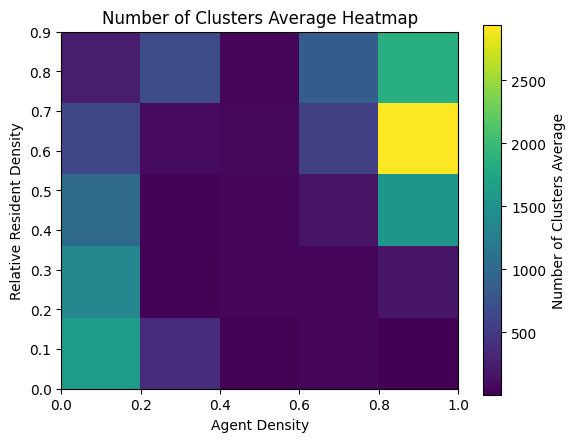

{(0.1, 0.1): 0.0, (0.1, 0.3): 0.0, (0.1, 0.5): 0.0, (0.1, 0.7): 0.0, (0.1, 0.9): 0.0, (0.325, 0.1): 0.0, (0.325, 0.3): 0.0, (0.325, 0.5): 0.0, (0.325, 0.7): 0.0, (0.325, 0.9): 0.0, (0.55, 0.1): 0.0, (0.55, 0.3): 0.0, (0.55, 0.5): 0.0, (0.55, 0.7): 0.0, (0.55, 0.9): 0.0, (0.775, 0.1): 0.0, (0.775, 0.3): 0.0, (0.775, 0.5): 0.0, (0.775, 0.7): 0.0, (0.775, 0.9): 0.0, (1.0, 0.1): 0.0, (1.0, 0.3): 0.0, (1.0, 0.5): 0.0, (1.0, 0.7): 0.0, (1.0, 0.9): 0.0}


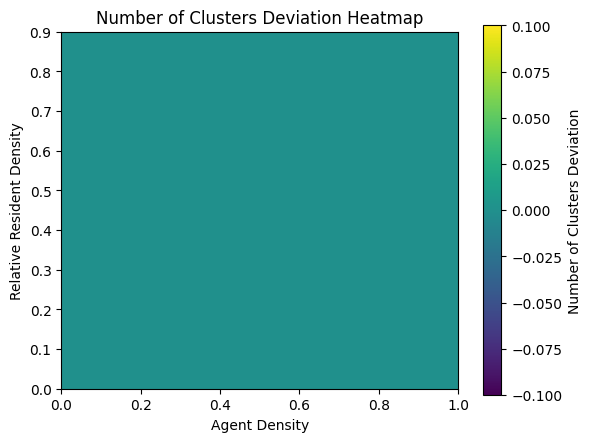

{(0.1, 0.1): 1.2, (0.1, 0.3): 1.2, (0.1, 0.5): 1.1, (0.1, 0.7): 1.1, (0.1, 0.9): 1.0, (0.325, 0.1): 17.4, (0.325, 0.3): 256.0, (0.325, 0.5): 140.6, (0.325, 0.7): 25.8, (0.325, 0.9): 1.1, (0.55, 0.1): 696.1, (0.55, 0.3): 146.8, (0.55, 0.5): 110.5, (0.55, 0.7): 55.4, (0.55, 0.9): 25.3, (0.775, 0.1): 327.0, (0.775, 0.3): 283.9, (0.775, 0.5): 53.8, (0.775, 0.7): 9.5, (0.775, 0.9): 2.0, (1.0, 0.1): 6750.0, (1.0, 0.3): 89.5, (1.0, 0.5): 7.3, (1.0, 0.7): 2.3, (1.0, 0.9): 1.2}


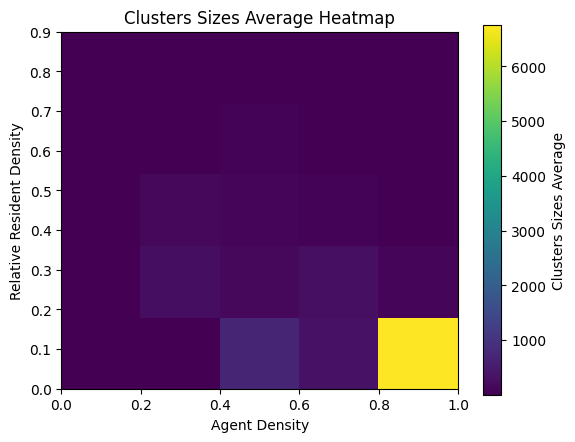

{(0.1, 0.1): 0.0, (0.1, 0.3): 0.0, (0.1, 0.5): 0.0, (0.1, 0.7): 0.0, (0.1, 0.9): 0.0, (0.325, 0.1): 0.0, (0.325, 0.3): 0.0, (0.325, 0.5): 0.0, (0.325, 0.7): 0.0, (0.325, 0.9): 0.0, (0.55, 0.1): 0.0, (0.55, 0.3): 0.0, (0.55, 0.5): 0.0, (0.55, 0.7): 0.0, (0.55, 0.9): 0.0, (0.775, 0.1): 0.0, (0.775, 0.3): 0.0, (0.775, 0.5): 0.0, (0.775, 0.7): 0.0, (0.775, 0.9): 0.0, (1.0, 0.1): 0.0, (1.0, 0.3): 0.0, (1.0, 0.5): 0.0, (1.0, 0.7): 0.0, (1.0, 0.9): 0.0}


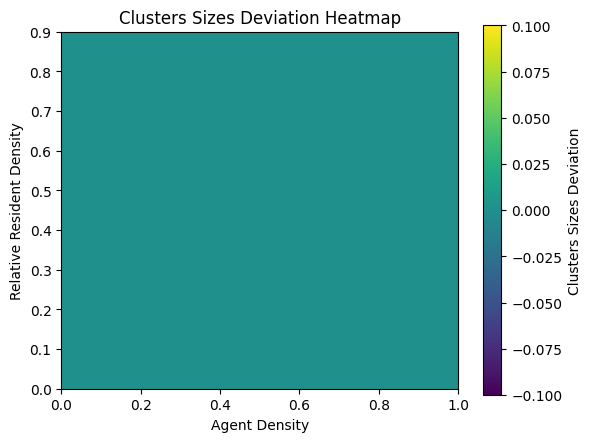

In [7]:
print(numClustersAverageDict)
generate_heatmap(numClustersAverageDict, 'Number of Clusters Average')
print(numClustersDeviationDict)
generate_heatmap(numClustersDeviationDict, 'Number of Clusters Deviation')
print(clustersSizesAverageDict)
generate_heatmap(clustersSizesAverageDict, 'Clusters Sizes Average')
print(clustersSizesDeviationDict)
generate_heatmap(clustersSizesDeviationDict, 'Clusters Sizes Deviation')